In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import sys
# np.set_printoptions(threshold=sys.maxsize)


In [2]:
def show(img):
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [3]:
def maxSize(lst):
    size = []
    for arr in lst:
        x,y,z = arr.shape
        size.append(x)
    maxpos = size.index(max(size))
    return(lst[maxpos])

In [13]:
def getROI(input_path , output_path):
    #read image and convert it to gray scale
    img_original = cv2.imread(input_path)
    h, w,_ = img_original.shape
    img0 = np.zeros((h+160,w,3), np.uint8)
    img0[80:-80,:] = img_original
    img = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    show(img)
    
    # smoothing the image
    blur = cv2.GaussianBlur(img,(5,5),0)
    plt.subplot(132)
    show(blur)
    
    # extract hand by gray scale threshold
    _, th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    plt.subplot(133)
    show(th)
    plt.tight_layout()
    plt.show()
    
    # use opencv moments to find out the centre of hand(x_c,y_c)
    M = cv2.moments(th)
    h, w = img.shape
    x_c = M['m10'] // M['m00']
    y_c = M['m01'] // M['m00']
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    show(th)
    plt.plot(x_c, y_c, 'bx', markersize=10)
    
    # set kernel and use erosion to find hand boundary
    kernel = np.array([[0, 1, 0],
                       [1, 1, 1],
                       [0, 1, 0]]).astype(np.uint8)
    erosion = cv2.erode(th,kernel,iterations=1)
    boundary = th - erosion
    
    # find the countours tree of the hand
    __, cnt, _ = cv2.findContours(boundary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_c = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # find the longest countour
    cnt = maxSize(cnt)

    # draw the countour
    img_cnt = cv2.drawContours(img_c, [cnt], 0, (255,0,0), 2)
    plt.subplot(122)
    plt.plot(x_c, y_c, 'bx', markersize=10)
    show(img_cnt)
    plt.tight_layout()
    plt.show()
    
    #find the distance between countor and the centre
    cnt = cnt.reshape(-1,2)

    left_id = np.argmin(cnt.sum(-1))

    cnt = np.concatenate([cnt[left_id:,:], cnt[:left_id,:]])
    
    dist_c = np.sqrt(np.square(cnt-[x_c, y_c]).sum(-1))
    f = np.fft.rfft(dist_c)
    
    
    # smoothing the dist graph
    cutoff = 15
    f_new = np.concatenate([f[:cutoff],0*f[cutoff:]])
    dist_c_1 = np.fft.irfft(f_new)
    plt.figure(figsize=(15,5))
    plt.grid()
    plt.plot(dist_c, label='Original ED function', color='r', linewidth='3', linestyle='--')
    plt.plot(dist_c_1, label='Low frequency reconstruction', color='b', linestyle='-')
    plt.legend()
    plt.show()
    
    
    # find the derivative and the minimas(valley of hand)
    derivative = np.diff(dist_c_1)
    sign_change = np.diff(np.sign(derivative))/2
    plt.figure(figsize=(15,5))
    plt.plot(sign_change)
    plt.plot(derivative)
    plt.axhline(y=0, color='r')
    plt.grid()
    plt.show()
    minimas = cnt[np.where(sign_change>0)[0]]
#     print(minimas)
    
    # v1, v2 are the valley points (middle, index) (ring, pinky)
    
    v1, v2 = minimas[-2], minimas[-4]
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    show(img)
    plt.plot(v1[0], v1[1],'rx')
    plt.plot(v2[0], v2[1],'bx')

    plt.subplot(132)
    theta = np.arctan2((v2-v1)[1], (v2-v1)[0])*180/np.pi
    print('The rotation of ROI is {:.02f}\u00b0'.format(theta))

    
    #*****************
    # sometimes may assign worng valley points
    if(theta > 33):
        v1, v2 = minimas[-1], minimas[-3]
        plt.figure(figsize=(15,5))
        plt.subplot(131)
        show(img)
        plt.plot(v1[0], v1[1],'rx')
        plt.plot(v2[0], v2[1],'bx')

        plt.subplot(132)
        theta = np.arctan2((v2-v1)[1], (v2-v1)[0])*180/np.pi    
        print('The rotation of ROI is {:.02f}\u00b0'.format(theta))

    #*****************




    # rotate the image to where v1 and v2 is horizontal
    R = cv2.getRotationMatrix2D(tuple(v2),theta,1)
    img_r = cv2.warpAffine(img0,R,(w,h))
    v1 = (R[:,:2] @ v1 + R[:,-1]).astype(np.int)
    v2 = (R[:,:2] @ v2 + R[:,-1]).astype(np.int)
    plt.plot(v1[0], v1[1],'rx')
    plt.plot(v2[0], v2[1],'bx')
    show(img_r)

    # location of ROI
    ux = v1[0]
    uy = v1[1] + (v2-v1)[0]//3
    lx = v2[0]
    ly = v2[1] + 4*(v2-v1)[0]//3
    # img_c = cv2.cvtColor(img_r, cv2.COLOR_GRAY2BGR)
    # cv2.rectangle(img_r, (lx,ly),(ux,uy),(0,255,0),2)
    # plt.subplot(133)
    # show(img_r)

    plt.tight_layout()
    plt.show()
    
    roi = img_r[uy:ly,ux:lx]
    plt.figure(figsize=(5,5))
    show(roi)
    cv2.imwrite(output_path,roi)

1 :


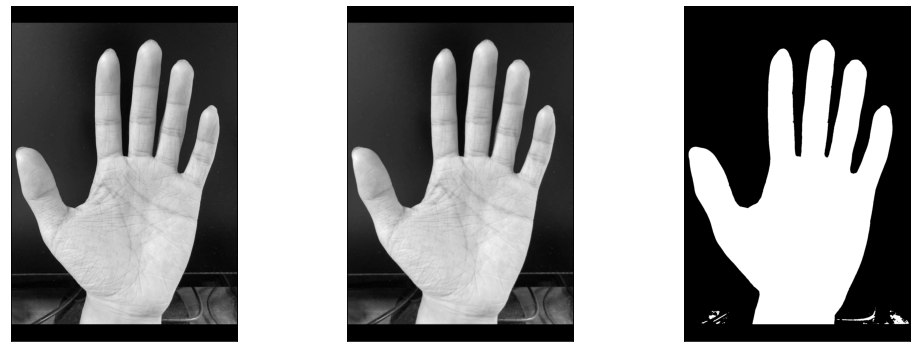

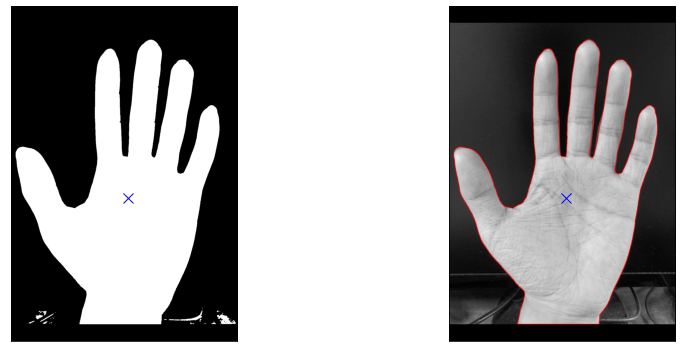

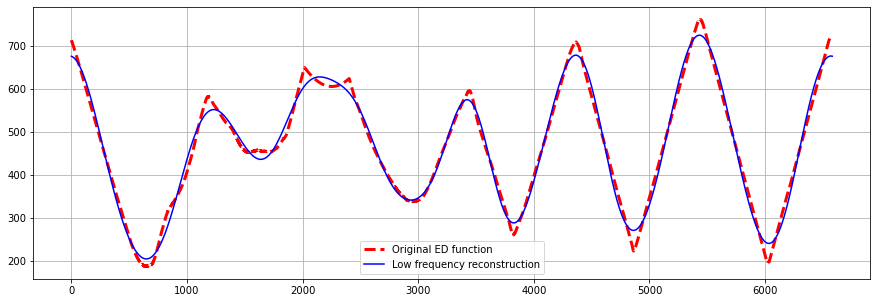

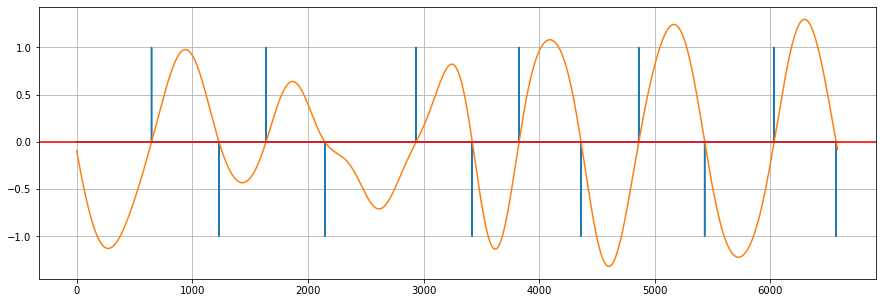

The rotation of ROI is 50.87°
The rotation of ROI is 16.07°


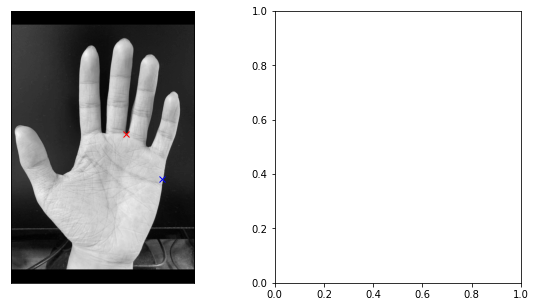

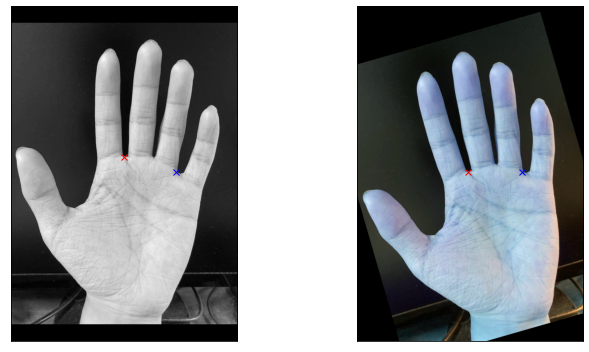

2 :


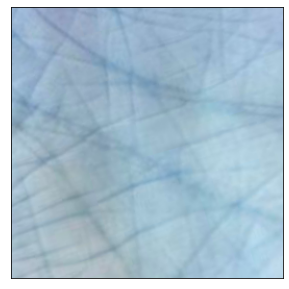

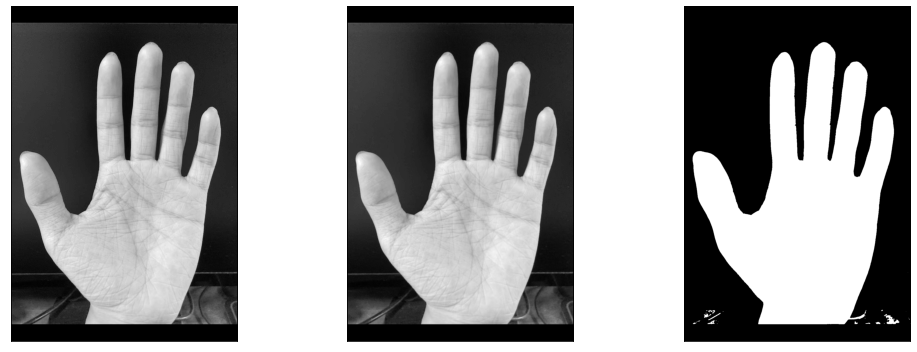

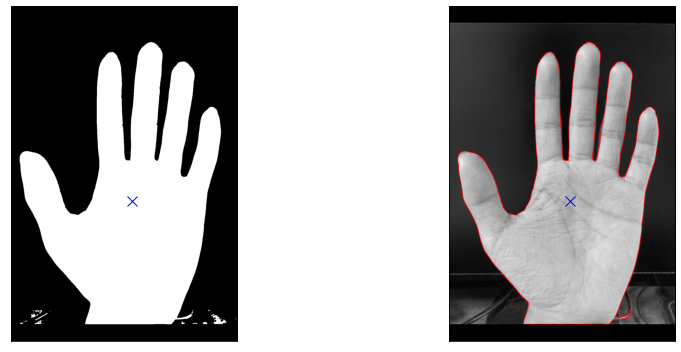

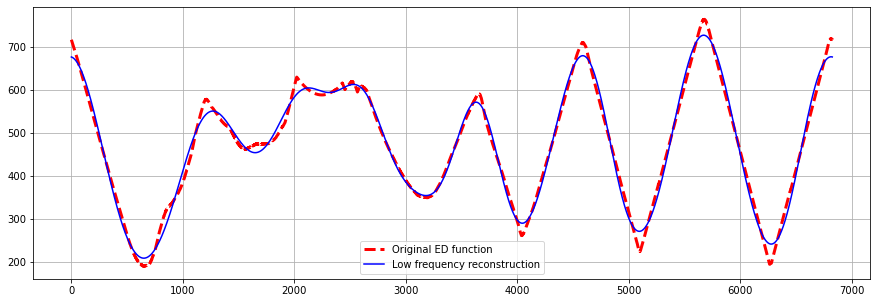

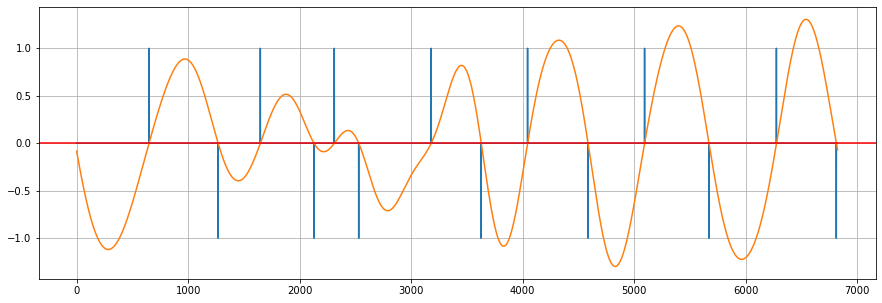

The rotation of ROI is 43.36°
The rotation of ROI is 14.93°


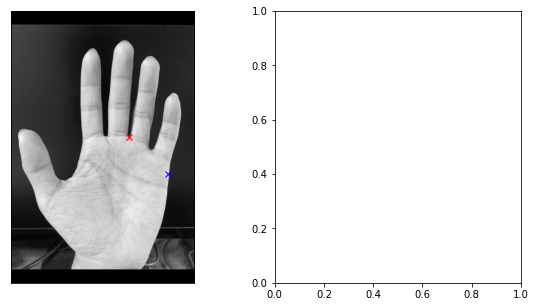

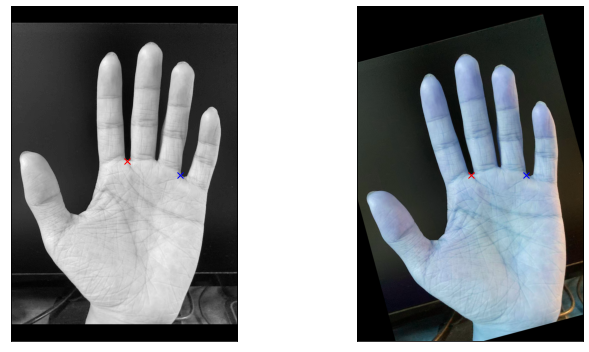

3 :


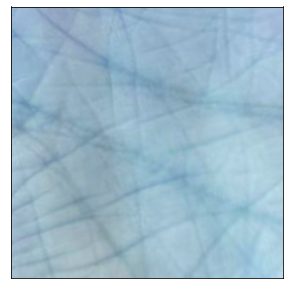

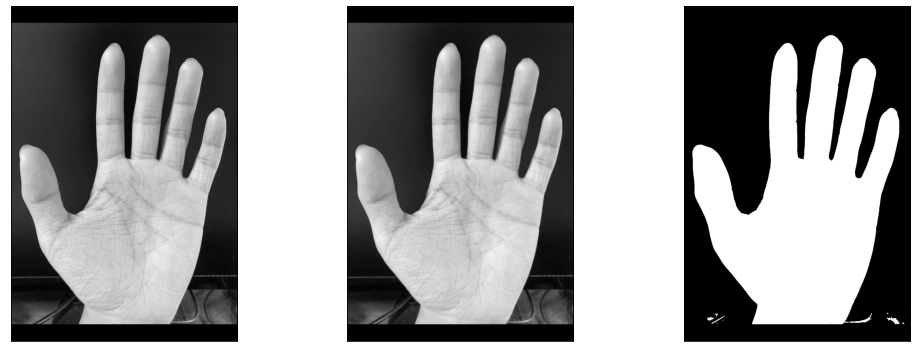

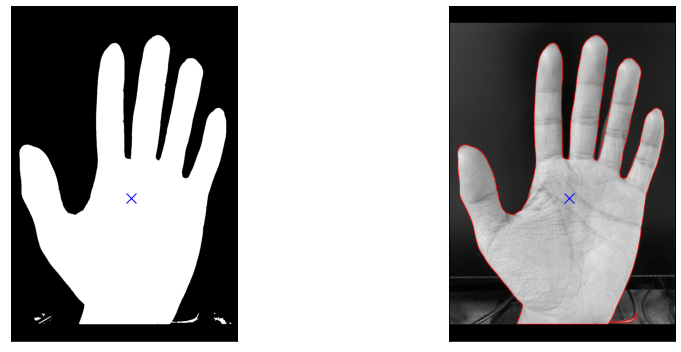

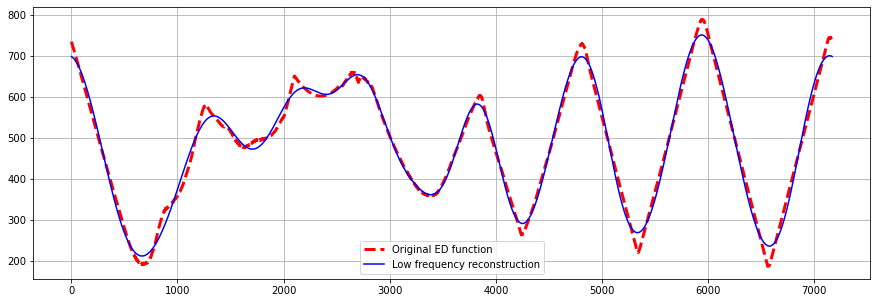

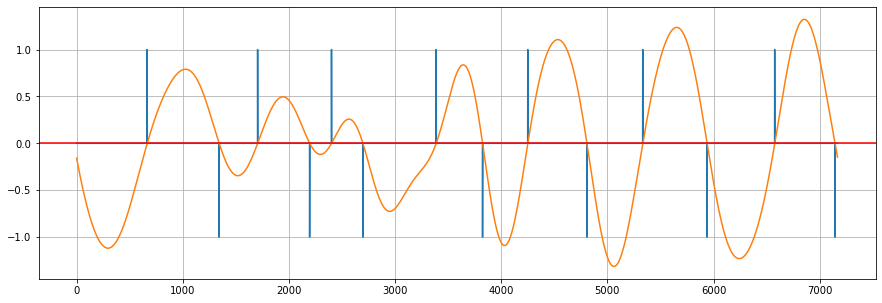

The rotation of ROI is 44.11°
The rotation of ROI is 16.70°


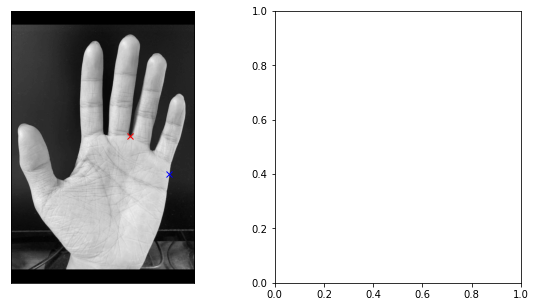

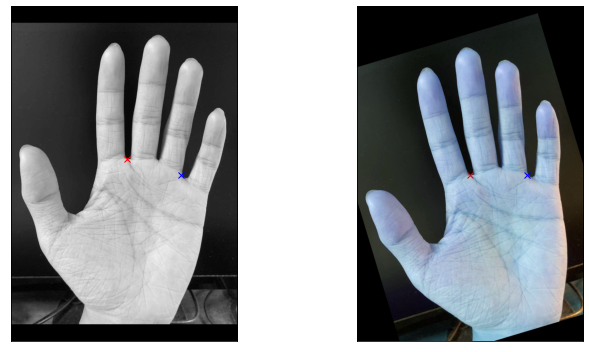

4 :


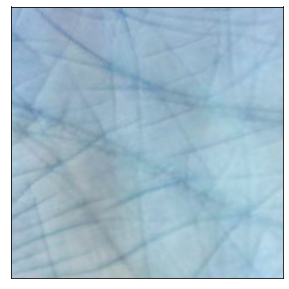

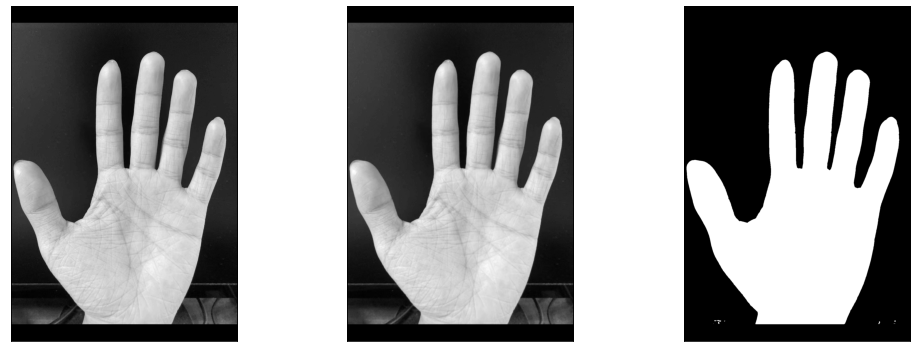

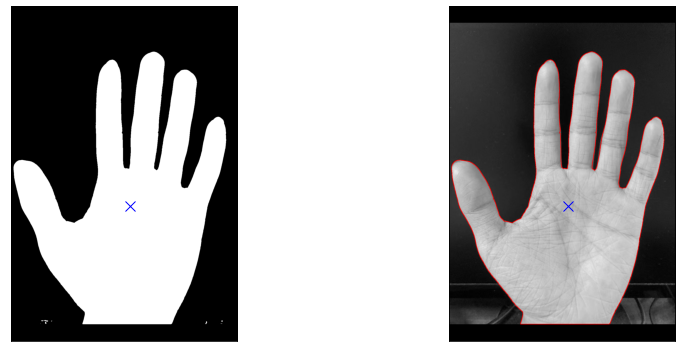

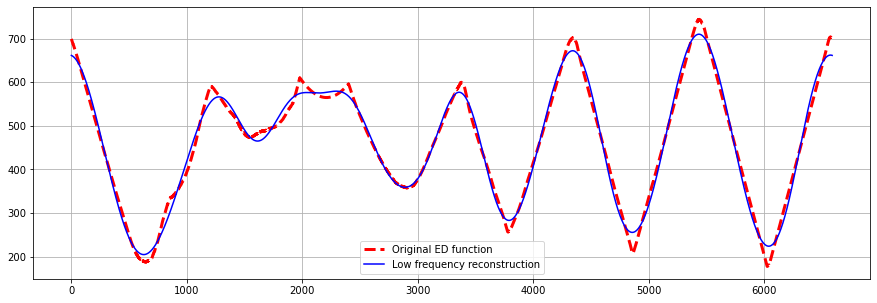

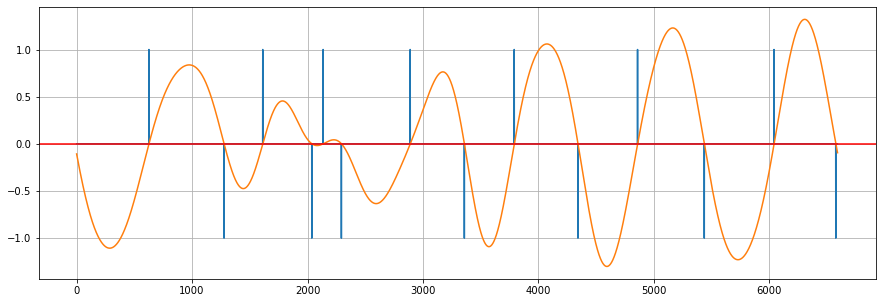

The rotation of ROI is 47.04°
The rotation of ROI is 16.84°


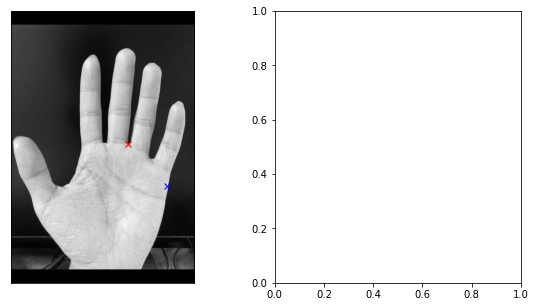

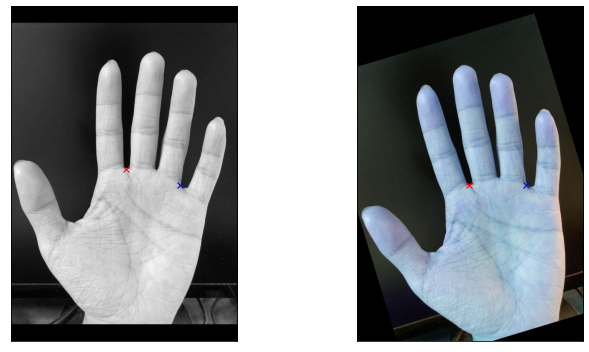

5 :


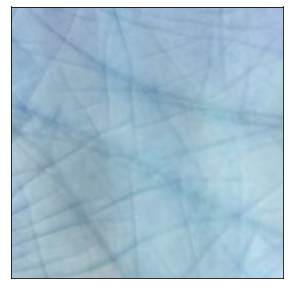

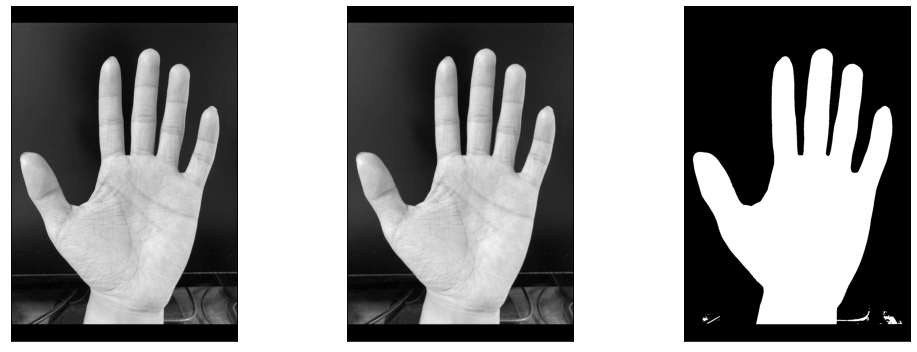

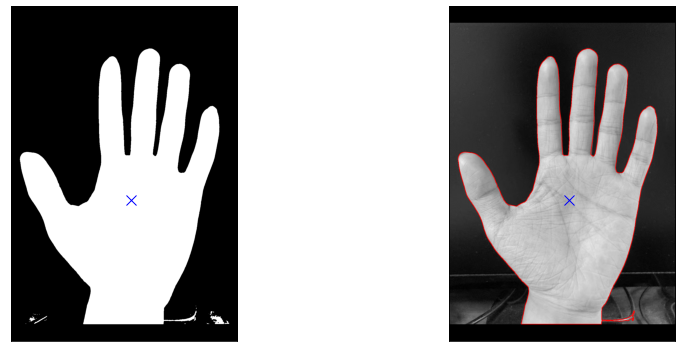

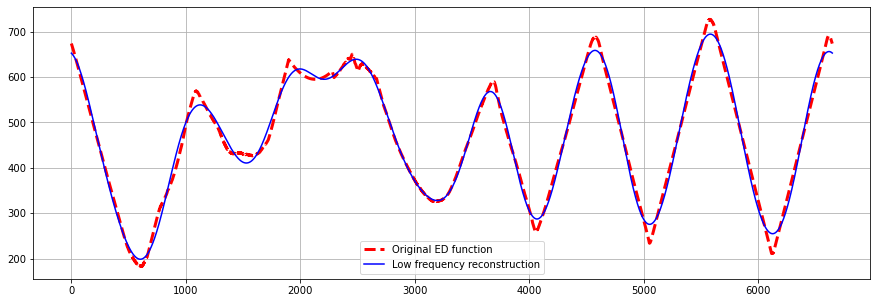

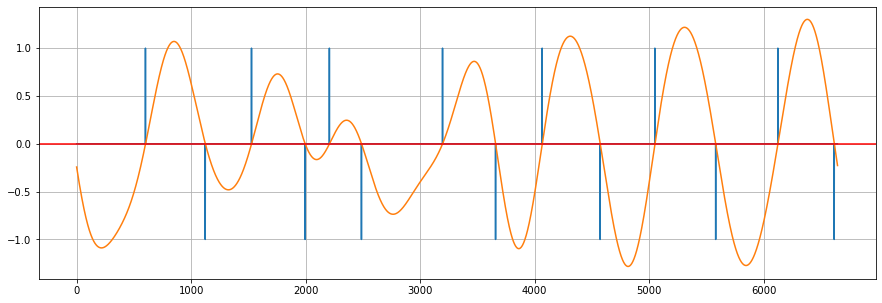

The rotation of ROI is 49.89°
The rotation of ROI is 15.72°


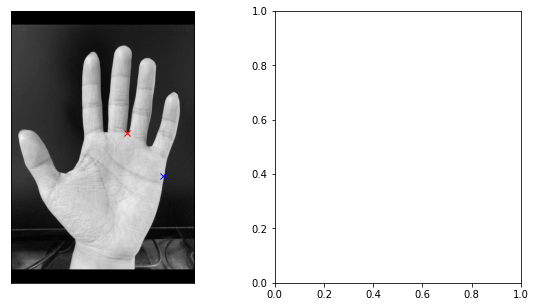

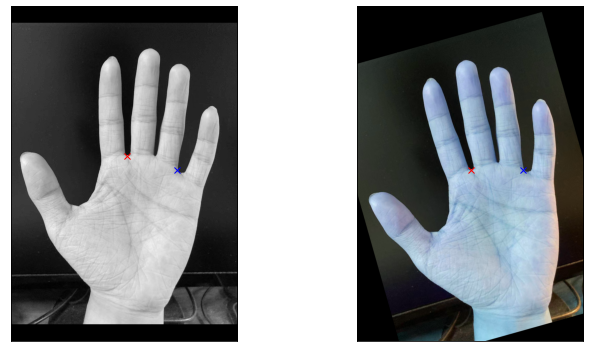

6 :


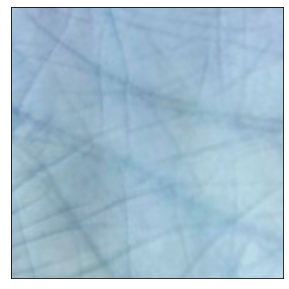

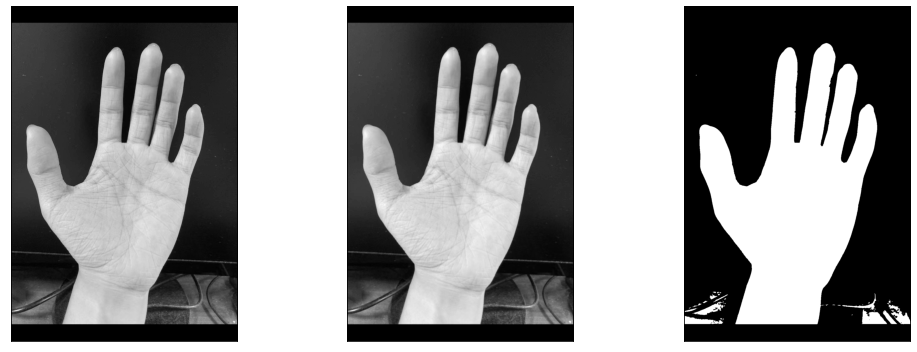

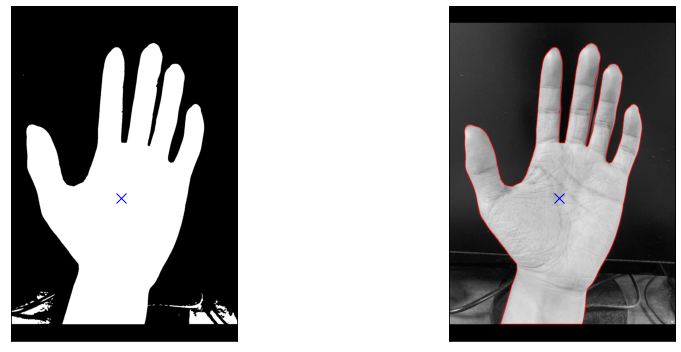

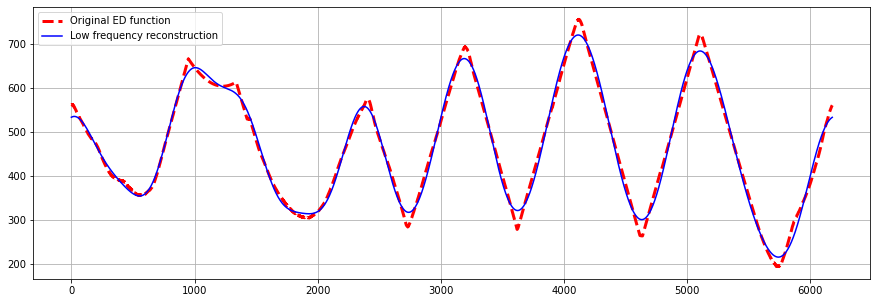

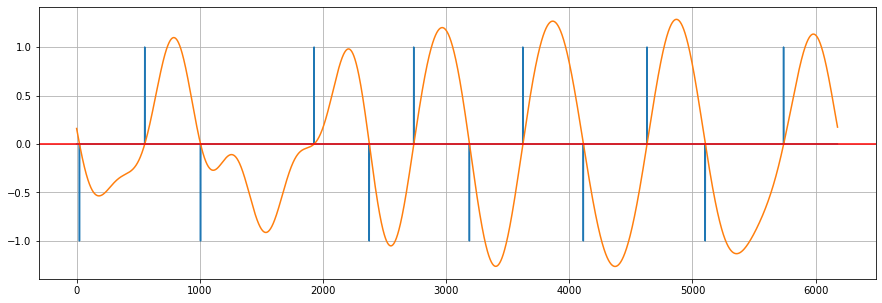

The rotation of ROI is 21.06°
The rotation of ROI is 21.06°


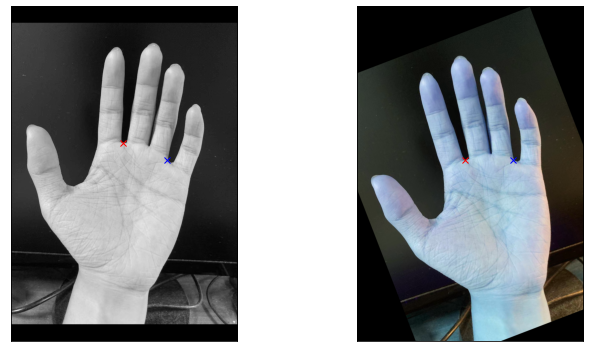

7 :


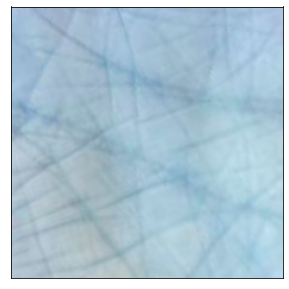

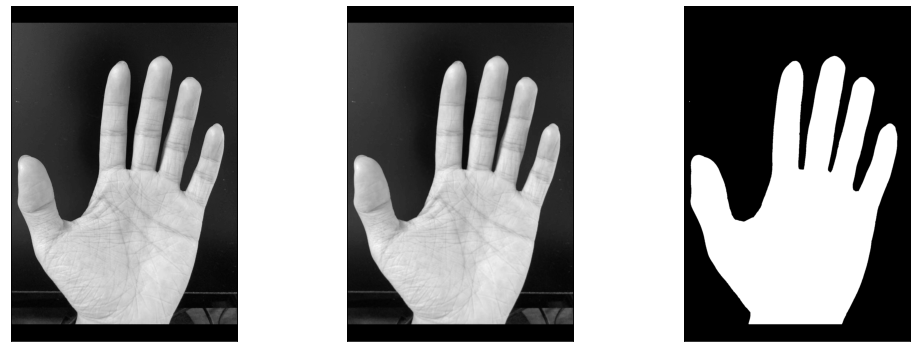

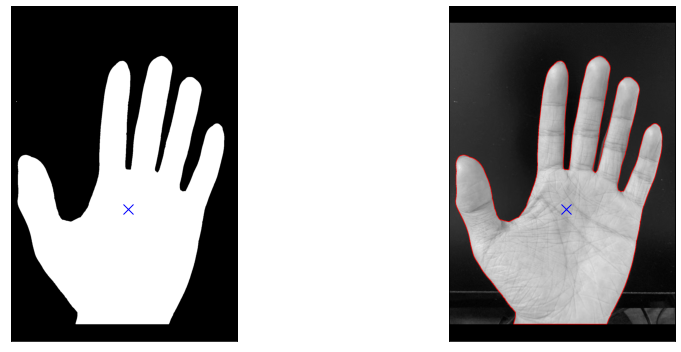

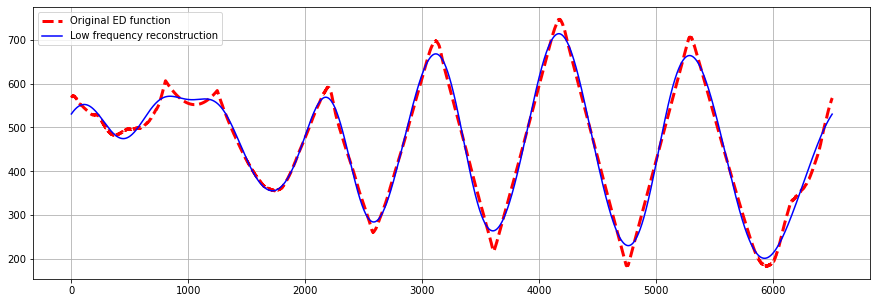

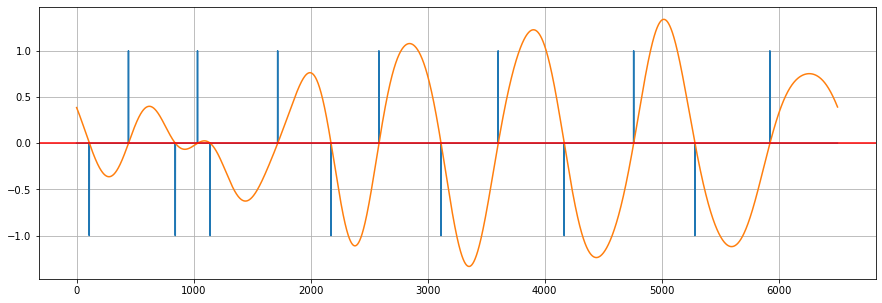

The rotation of ROI is 19.58°
The rotation of ROI is 19.58°


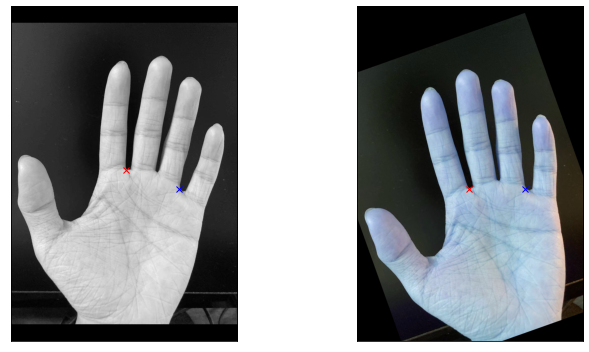

8 :


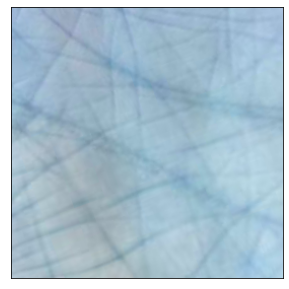

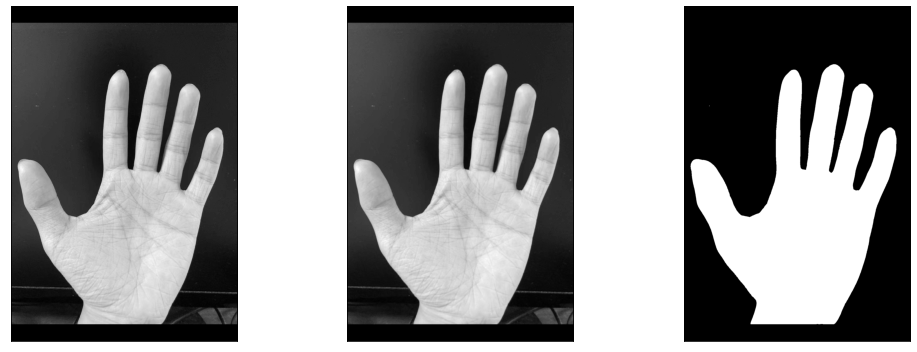

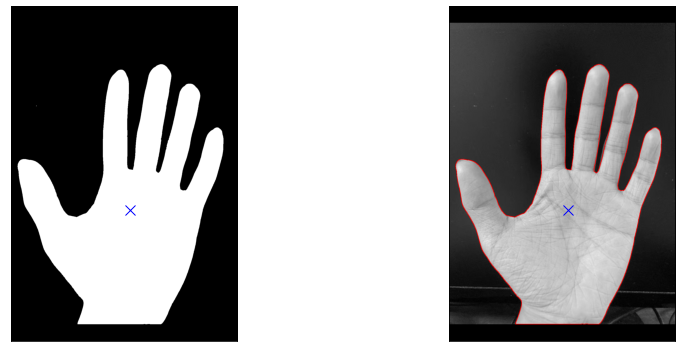

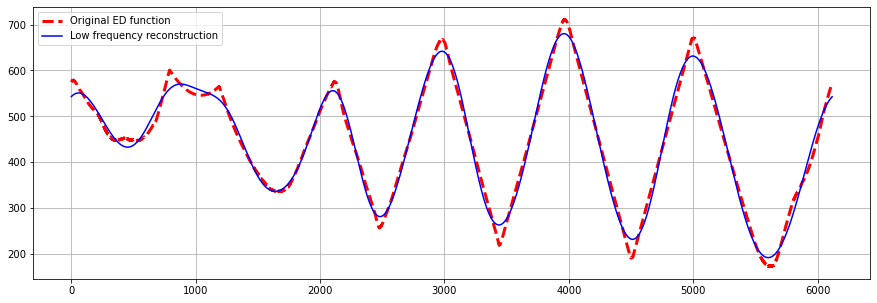

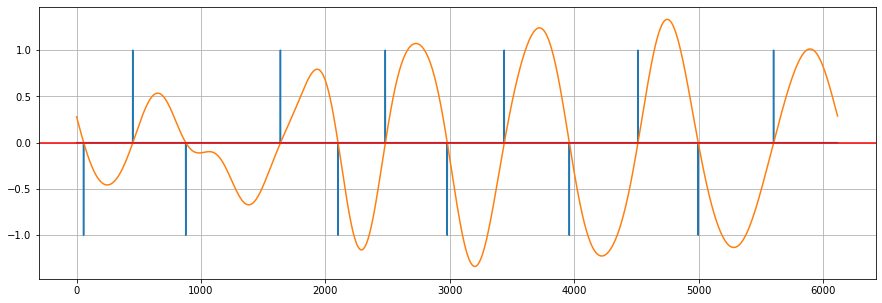

The rotation of ROI is 20.14°
The rotation of ROI is 20.14°


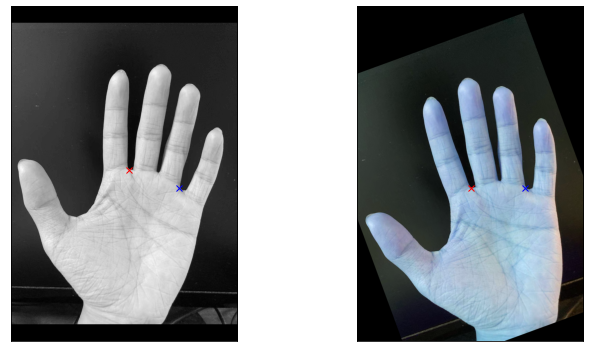

9 :


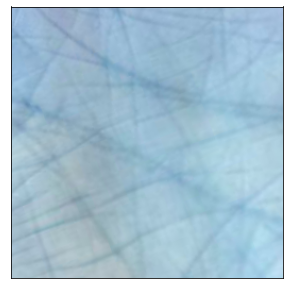

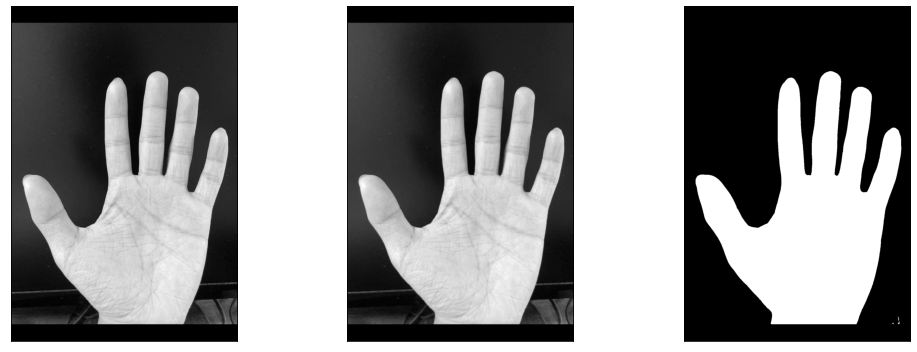

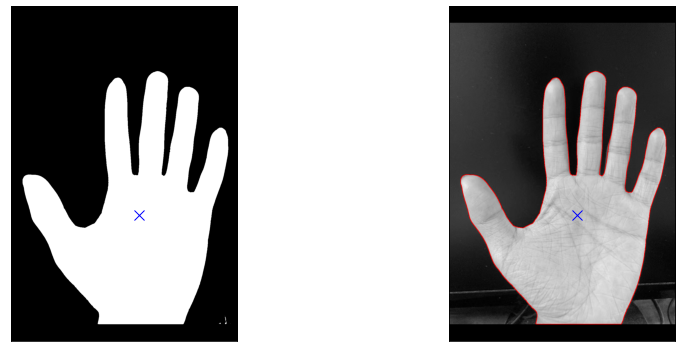

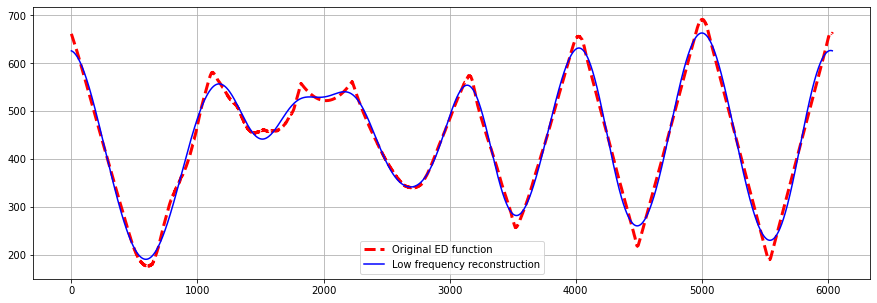

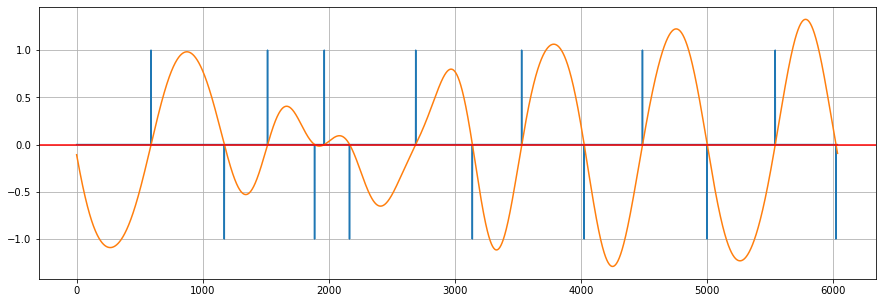

The rotation of ROI is 48.06°
The rotation of ROI is 15.22°


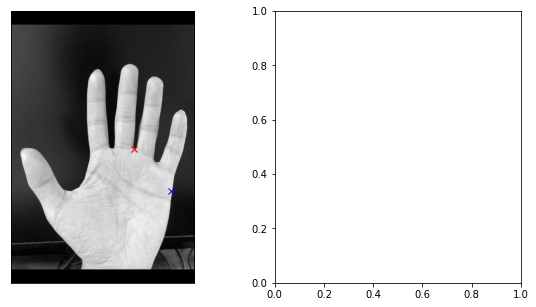

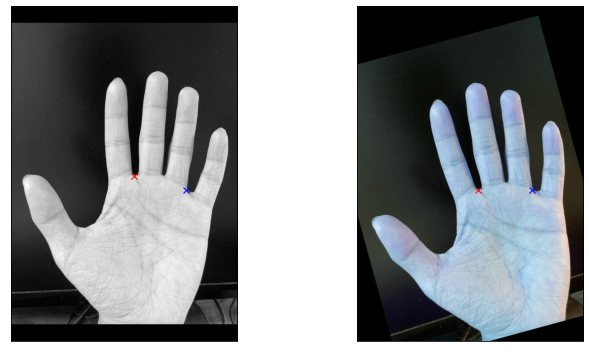

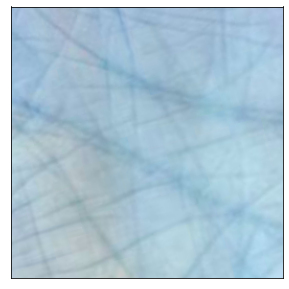

In [14]:
for i in range(1,10):
    print(i,':')
    inp = './images/original/tommy/test' + str(i) + '.jpg'
    outp = './images/roi/tommy/test' + str(i) + '.jpg'
    getROI(inp,outp)



1 :


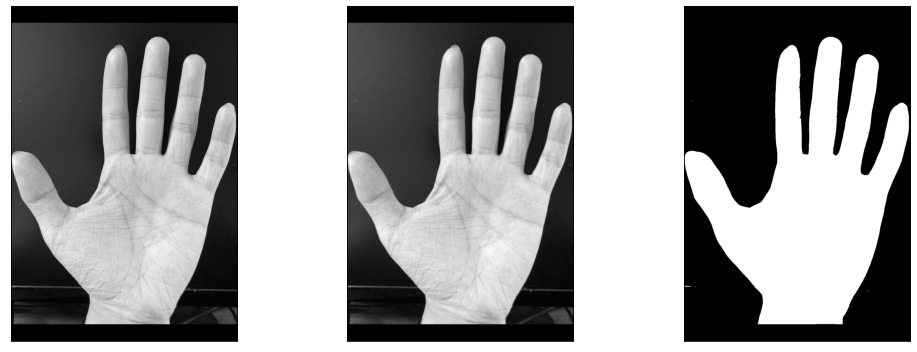

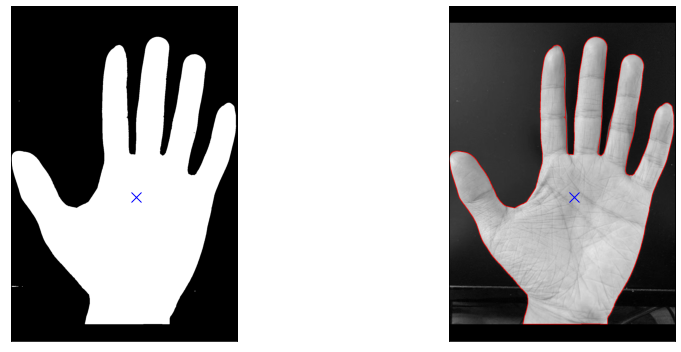

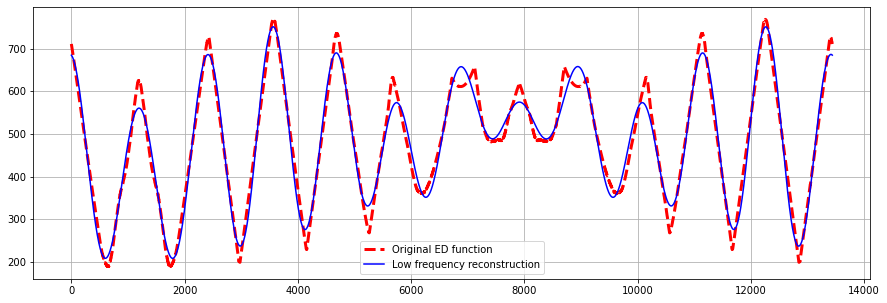

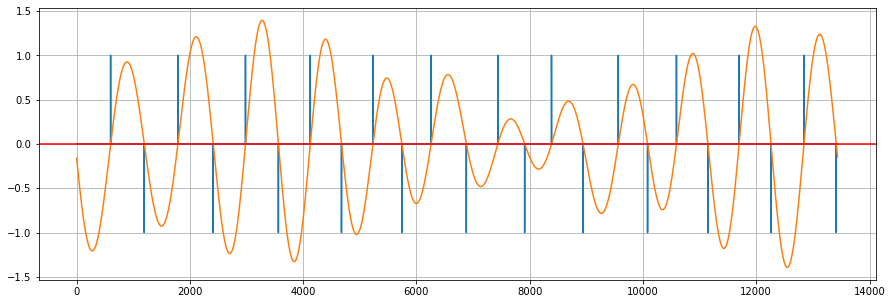

The rotation of ROI is 59.01°
The rotation of ROI is 15.55°


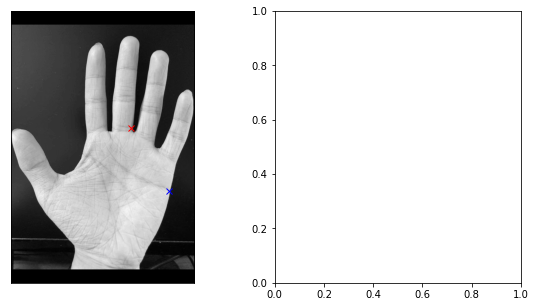

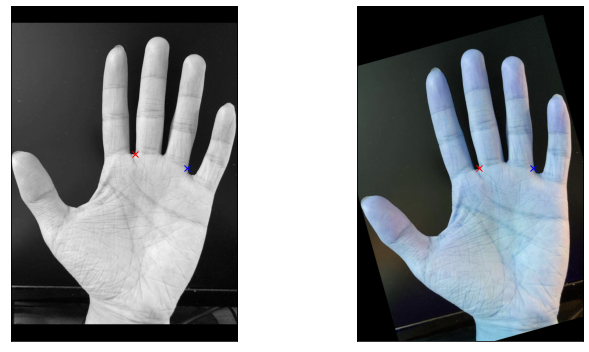

2 :


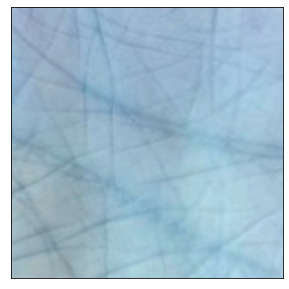

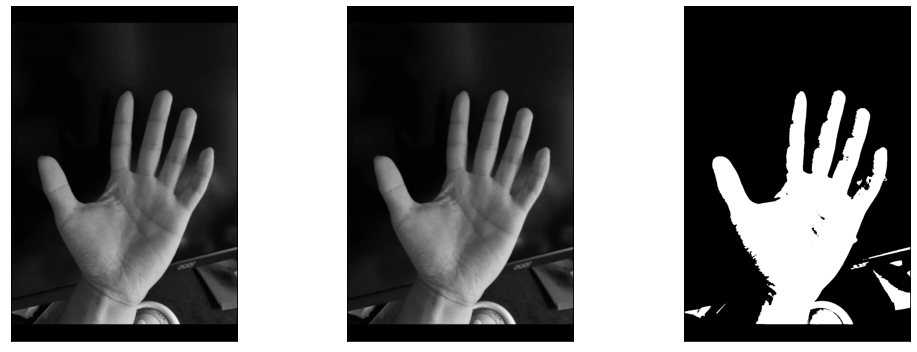

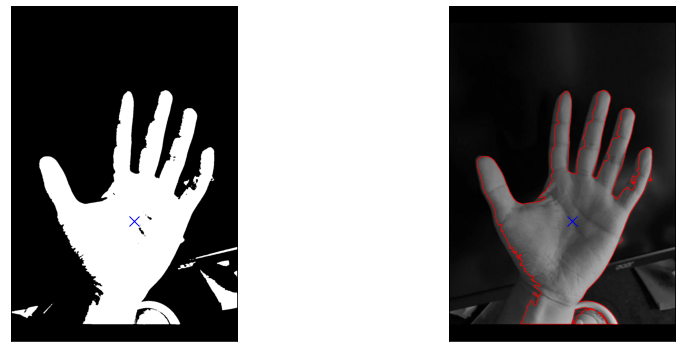

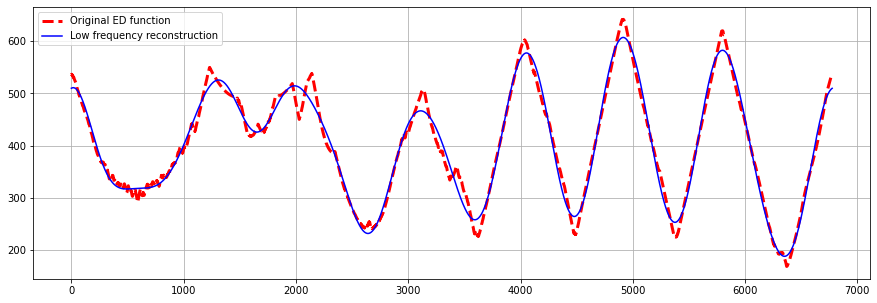

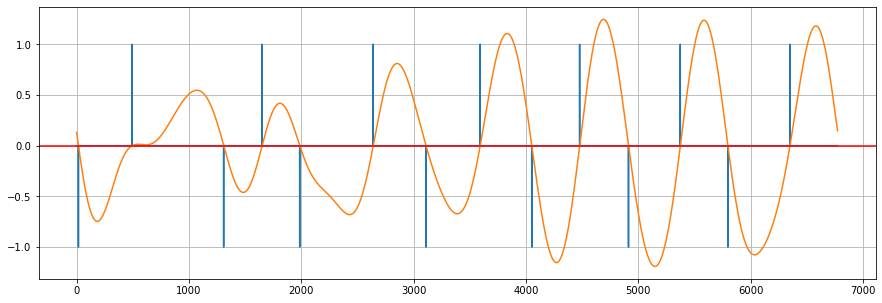

The rotation of ROI is 31.92°
The rotation of ROI is 31.92°


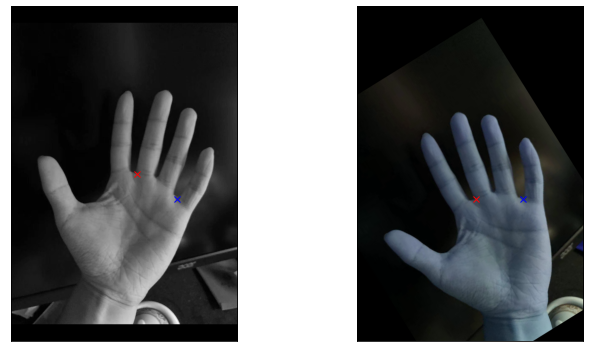

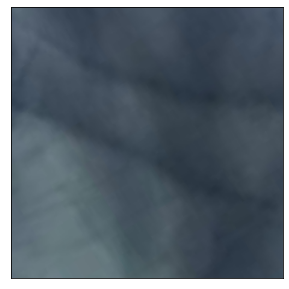

In [15]:
for i in range(1,3):
    print(i,':')
    inp = './images/original/tommy/tommy' + str(i) + '.jpg'
    outp = './images/roi/tommy/tommy' + str(i) + '.jpg'
    getROI(inp,outp)


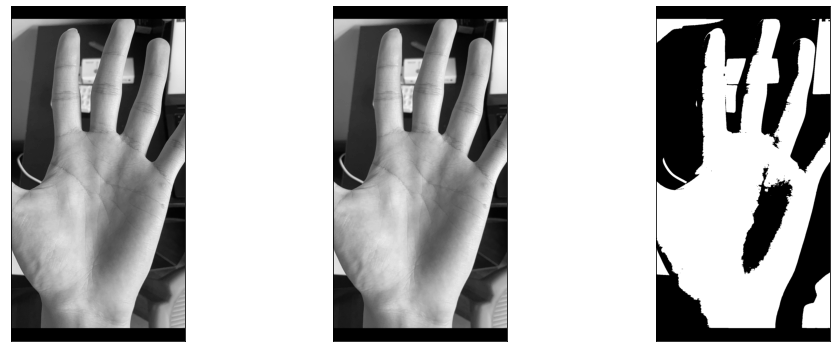

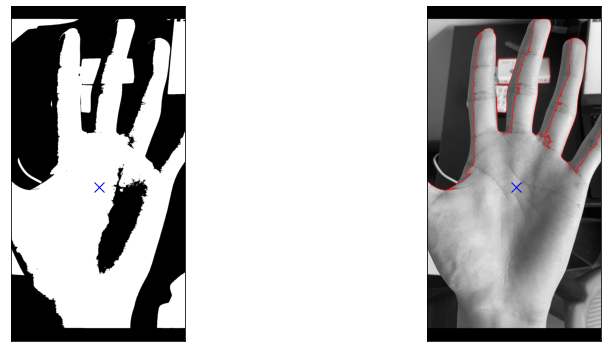

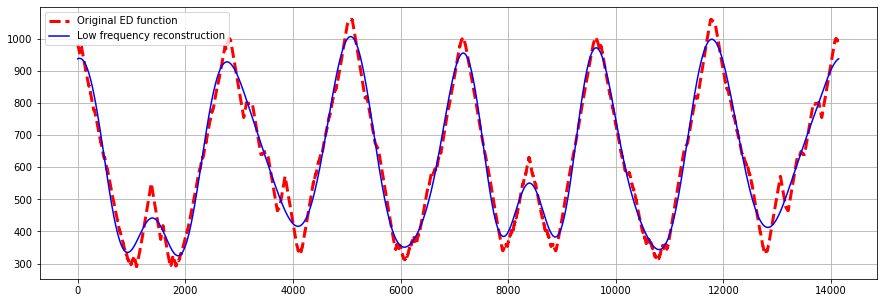

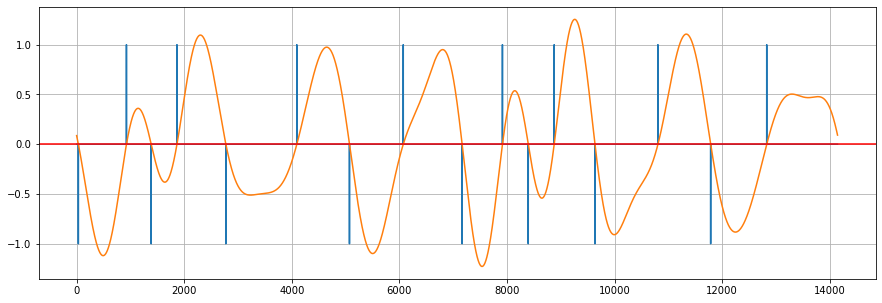

The rotation of ROI is 37.02°
The rotation of ROI is 23.44°


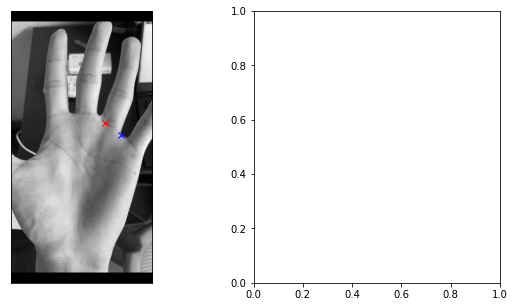

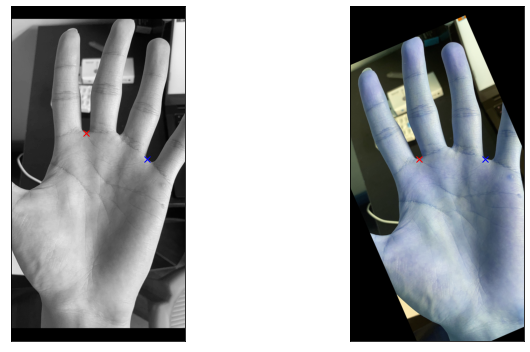

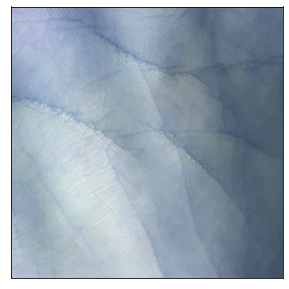

In [16]:


inp = './images/original/eddy/eddy1.jpg'
outp = './images/roi/eddy/eddy1.jpg'
getROI(inp,outp)
